In [3]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model  import ARIMA


In [7]:
def wrangle(data_path):
    
    data = pd.read_csv(data_path)
    
    def dropping_and_conversions(df):
        # Convert the currency to USD for all of them
        df.loc[df["currency"] == "USD", "cost_zar"] = df["cost"] * 19.18
        df.loc[df["currency"] != "USD", "cost_zar"] = df["cost"]
        df.drop(["cost", "currency", "display_location", "call_type", "call_status", "start_time" ,"end_time", "duration", "conversions", "conversions_calls", "impression_share"], axis=1, inplace=True)
        
        df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
        return df

    df = dropping_and_conversions(data)

    def filling_ad_type(df=df):
        ad_1 = df[df.ad_type == "EXPANDED_TEXT_AD"]
        ad_2 = df[df.ad_type == "EXPANDED_DYNAMIC_SEARCH_AD"]
        ad_3 = df[df.ad_type == "RESPONSIVE_SEARCH_AD"]

        def determine_ad_type(row):
            if pd.isnull(row["ad_type"]):
                if row["headline1_len"] in range(0, 2):
                    return "EXPANDED_DYNAMIC_SEARCH_AD"
                elif ((ad_1.headline1_len.mean() - ad_1.headline1_len.std()) <= row["headline1_len"] <= ad_1.headline1_len.mean() + ad_1.headline1_len.std()) and \
                    (ad_1.headline2_len.mean() - ad_1.headline2_len.std() <= row["headline2_len"] <= ad_1.headline2_len.mean() + ad_1.headline2_len.std()) and \
                    (ad_1.ad_description_len.mean() - ad_1.ad_description_len.std() <= row["ad_description_len"] <= ad_1.ad_description_len.mean() + ad_1.ad_description_len.std()):
                    return "EXPANDED_TEXT_AD"
                elif ((ad_3.headline1_len.mean() - ad_3.headline1_len.std()) <= row["headline1_len"] <= ad_3.headline1_len.mean() + ad_3.headline1_len.std()) and \
                    (ad_3.headline2_len.mean() - ad_3.headline2_len.std() <= row["headline2_len"] <= ad_3.headline2_len.mean() + ad_3.headline2_len.std()) and \
                    (ad_3.ad_description_len.mean() - ad_3.ad_description_len.std() <= row["ad_description_len"] <= ad_3.ad_description_len.mean() + ad_3.ad_description_len.std()):
                    return "RESPONSIVE_SEARCH_AD"
                else:
                    return row["ad_type"]  # Garde la valeur existante si aucune condition n'est remplie
            else:
                return row["ad_type"]

        df["ad_type"] = df.apply(determine_ad_type, axis=1)

        return df


    df= filling_ad_type(df)

    ##### Create dictionnaries of clients #####
    client_dic = {}

    for client in df.ID.unique():
        group = df[df.ID==client].set_index("date")
        group.drop(columns="ID", inplace=True)
        campains_data = group.drop(columns = ["headline1_len", "headline2_len", "ad_description_len"])
        ad_characteristics = group[["headline1_len", "headline2_len", "ad_description_len"]]
        campains_data_resampled = campains_data.resample("W").sum().fillna(method = "ffill")
        ad_characteristics_resampled = round(ad_characteristics.resample("W").mean()+0.5, 0).fillna(method = "ffill")
        group_resampled = pd.concat([campains_data_resampled, ad_characteristics_resampled], axis=1)
        #group_resampled["month"] = group_resampled.index.month
        group_resampled.select_dtypes("number").fillna("median", inplace= True)
        client_dic[client] = group_resampled

    def ad_type_per_week(data):
        # Create new variables for ad_type
        data["EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
        data["EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
        data["RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
        data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)
        data.drop("ad_type", axis=1, inplace=True)
        return data
    
    for group in client_dic.values():
        group = ad_type_per_week(group)

    return client_dic

In [8]:
data = wrangle("Data/Train.csv")
data_to_work = data["ID_5da86e71bf5dee4cf5047046"]
display(data)
display(data_to_work.head())

{'ID_5da86e71bf5dee4cf5047046':             impressions  clicks  conversions call_type call_status start_time  \
 date                                                                            
 2020-01-05       2134.0   246.0          0.0         0           0          0   
 2020-01-12       3463.0   410.0          0.0         0           0          0   
 2020-01-19       4074.0   405.0          0.0         0           0          0   
 2020-01-26       4544.0   445.0          0.0         0           0          0   
 2020-02-02       4822.0   450.0          0.0         0           0          0   
 ...                 ...     ...          ...       ...         ...        ...   
 2023-12-17       7942.0   527.0          0.0         0           0          0   
 2023-12-24       4411.0   279.0          0.0         0           0          0   
 2023-12-31       4777.0   353.0          0.0         0           0          0   
 2024-01-07       9524.0   817.0          0.0         0           0

,impressions,clicks,conversions,call_type,call_status,start_time,duration,end_time,impression_share,conversions_calls,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,,,,,,,,,,,,
2020-01-05,2134.0,246.0,0.0,0,0,0,0.0,0,590.875094,0.0,46715.0,2.0,4.0,12.0,True,False,False
2020-01-12,3463.0,410.0,0.0,0,0,0,0.0,0,991.318917,0.0,69443.0,2.0,4.0,12.0,True,False,False
2020-01-19,4074.0,405.0,0.0,0,0,0,0.0,0,1207.390413,0.0,67481.0,2.0,3.0,12.0,True,True,False
2020-01-26,4544.0,445.0,0.0,0,0,0,0.0,0,1246.425681,0.0,67422.0,2.0,3.0,12.0,True,True,False
2020-02-02,4822.0,450.0,0.0,0,0,0,0.0,0,1194.367235,0.0,65477.0,2.0,3.0,12.0,True,True,False


In [9]:
data_to_work.to_csv("Data/ID_5da86e71bf5dee4cf5047046_datas.csv")

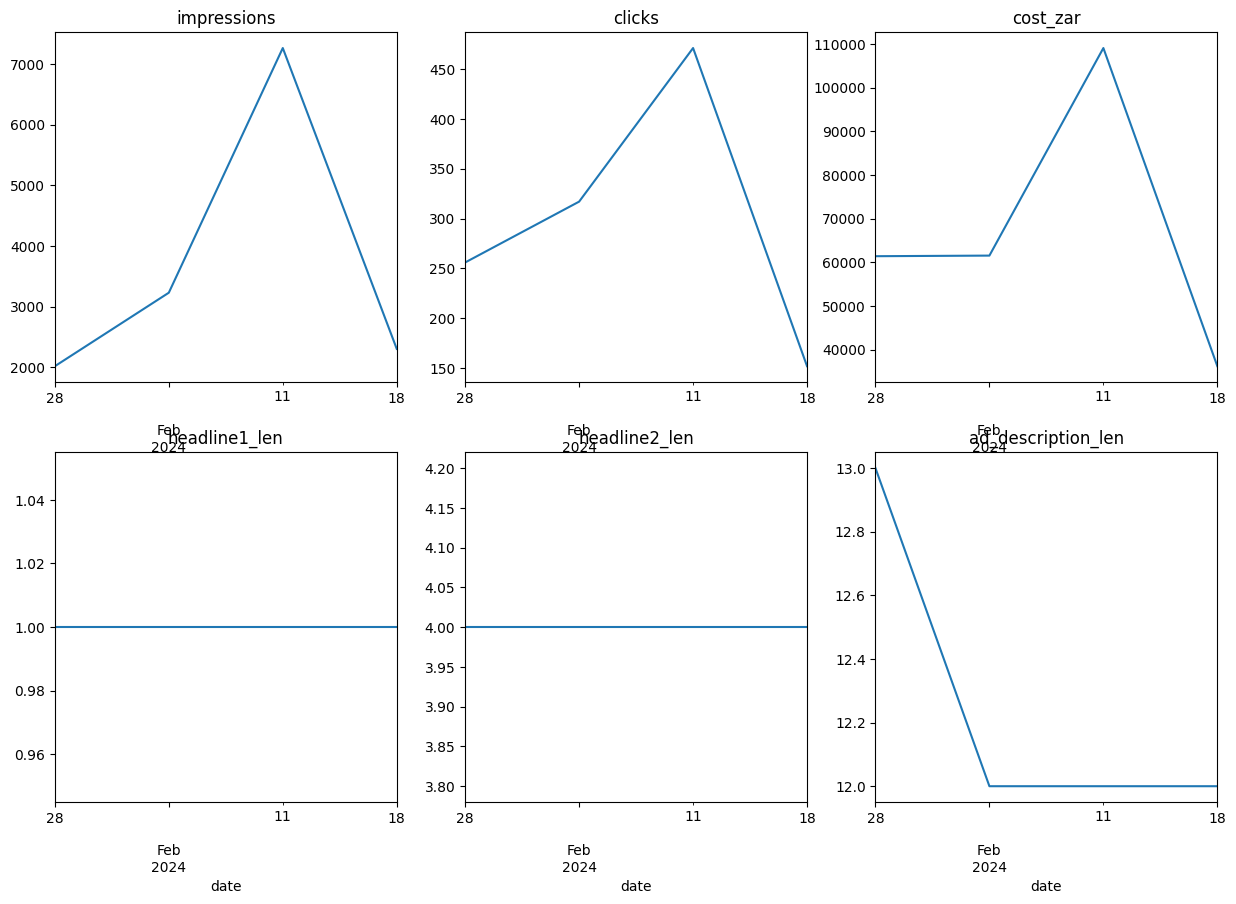

In [46]:
fig, ax = plt.subplots(figsize=(15, 10), nrows = 2, ncols = 3)
for i, col in enumerate(data_to_work.select_dtypes("number").columns):
    data_to_work.select_dtypes("number")[col].plot(ax=ax[i//3, i%3], title = col)

In [47]:
data_to_work.index

DatetimeIndex(['2024-01-28', '2024-02-04', '2024-02-11', '2024-02-18'], dtype='datetime64[ns]', name='date', freq='W-SUN')

In [49]:
result = seasonal_decompose(data_to_work['clicks'], model="additive")
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(10, 12);

ValueError: x must have 2 complete cycles requires 104 observations. x only has 4 observation(s)

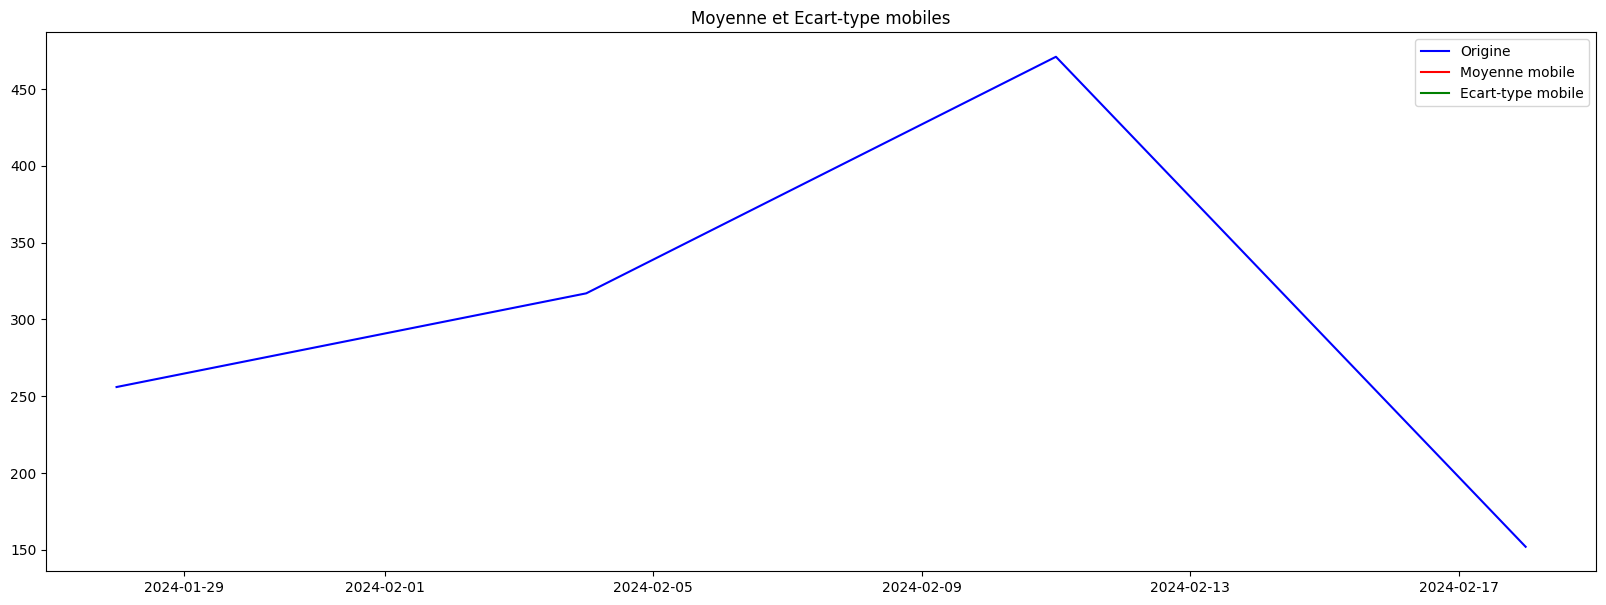

In [50]:
rolling_mean = data_to_work["clicks"].rolling(window = 7).mean()
rolling_std = data_to_work["clicks"].rolling(window = 7).std()
plt.figure(figsize=(20, 7))
plt.plot(data_to_work["clicks"], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'green', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

Comment : We see a that the moving average and the moving std change over time. We can expect the serie to be non-stationnary

In [51]:
result = adfuller(data_to_work['clicks'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -1.990725123890919
p-value : 0.29065455792754935
Valeurs Critiques :
	1%: -10.41719074074074
	5%: -5.77838074074074
	10%: -3.391681111111111


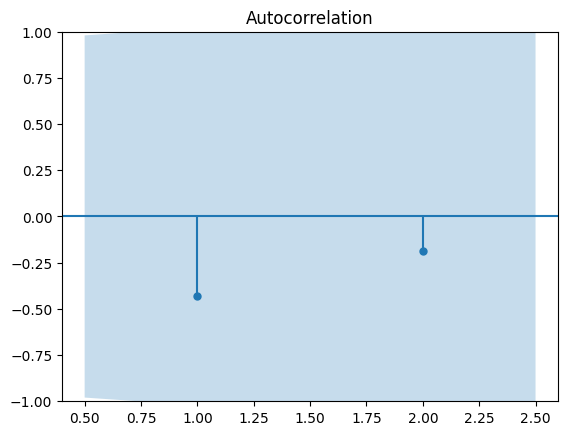

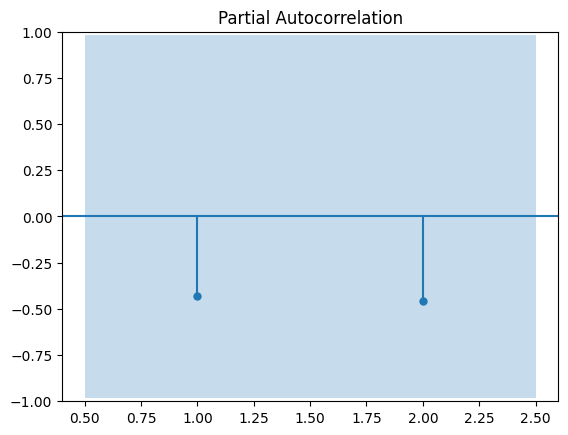

In [53]:
plot_acf(data_to_work.clicks, zero=False);
plot_pacf(data_to_work.clicks, zero=False);

In [54]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()
    
    # Set the dimensions of the plot window
    plt.figure(figsize=(15, 7))
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='green', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

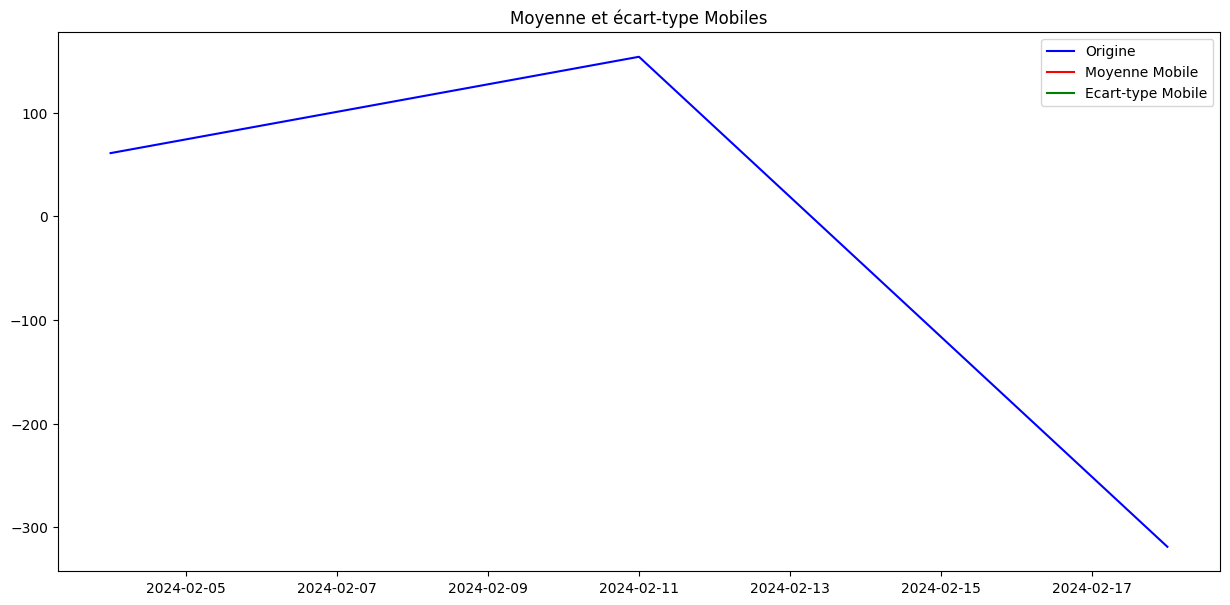

ValueError: sample size is too short to use selected regression component

In [55]:
var_diff_1 = data_to_work.clicks-data_to_work.clicks.shift(1)
var_diff_1.dropna(inplace=True)
get_stationarity(var_diff_1)

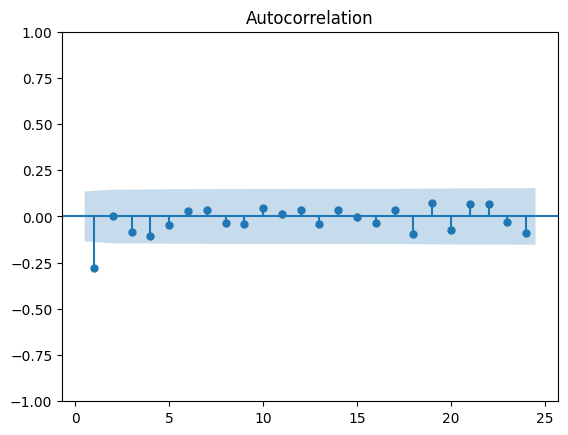

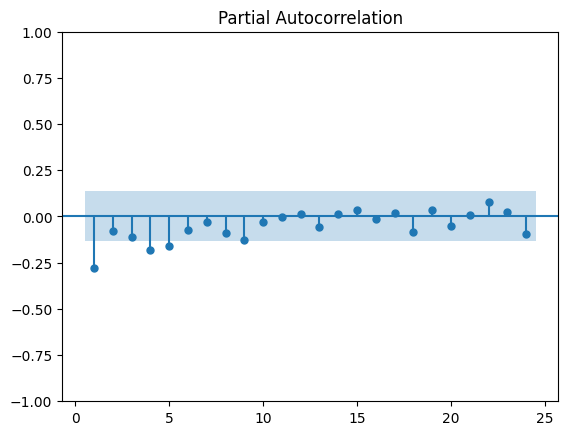

In [ ]:
plot_acf(var_diff_1, zero=False);
plot_pacf(var_diff_1, zero=False);

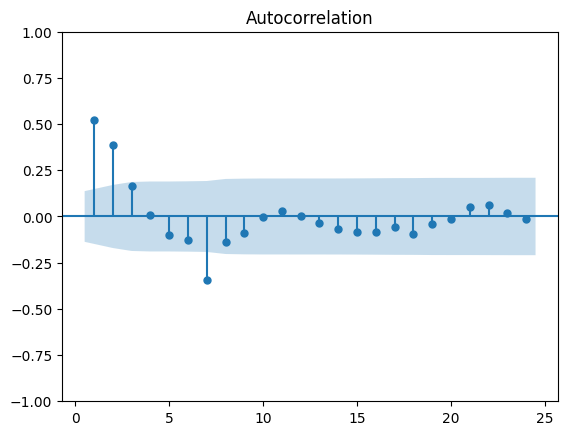

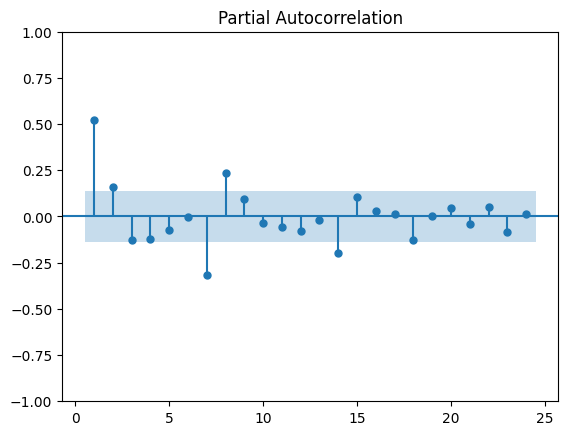

In [ ]:
z = data_to_work.clicks - data_to_work.clicks.shift(7)
z.dropna(inplace=True)
plot_acf(z, zero=False);
plot_pacf(z, zero=False);

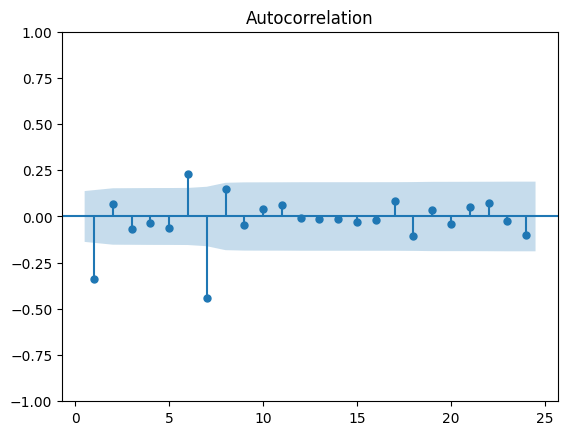

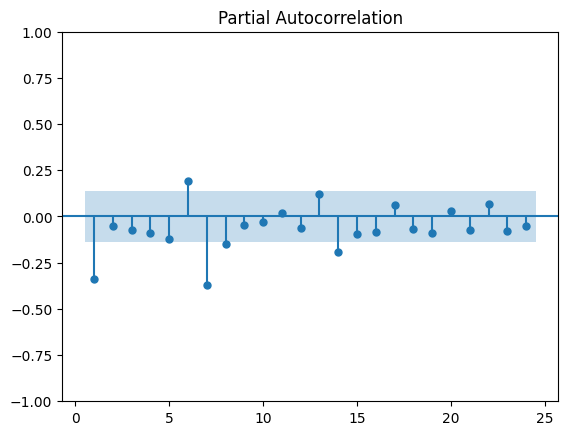

In [ ]:
z1 = z - z.shift(1)
z1.dropna(inplace=True)
plot_acf(z1, zero=False);
plot_pacf(z1, zero=False);

In [56]:
data_to_work_numerics = data_to_work.select_dtypes("number")
data_to_work_numerics.corr().style.background_gradient()

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,impressions,clicks,cost_zar,headline1_len,headline2_len,ad_description_len
impressions,1.000000,0.907631,0.923902,nan,nan,-0.462644
clicks,0.907631,1.000000,0.977539,nan,nan,-0.214934
cost_zar,0.923902,0.977539,1.000000,nan,nan,-0.123841
headline1_len,nan,nan,nan,nan,nan,nan
headline2_len,nan,nan,nan,nan,nan,nan
ad_description_len,-0.462644,-0.214934,-0.123841,nan,nan,1.000000


In [57]:
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(data_to_work_numerics.drop(columns="clicks").values, i) for i in range(len(data_to_work_numerics.drop(columns="clicks").columns))]
vif_data["Feature Name"] = data_to_work_numerics.drop(columns="clicks").columns
vif_data

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,VIF,Feature Name
0,43.003492,impressions
1,34.325495,cost_zar
2,0.000000,headline1_len
3,0.000000,headline2_len
4,6.393974,ad_description_len


In [71]:
target = "clicks"
X = data_to_work.drop(target, axis =1).astype(int)
#X"EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = X[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].astype(int) 
y = data_to_work[target]

In [72]:
display(X.head(), y.head())

,impressions,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,,,
2024-01-28,2020,61377,1,4,13,0,1,1
2024-02-04,3231,61515,1,4,12,0,1,1
2024-02-11,7262,109045,1,4,12,0,1,1
2024-02-18,2305,36186,1,4,12,0,1,1


date
2024-01-28    256.0
2024-02-04    317.0
2024-02-11    471.0
2024-02-18    152.0
Freq: W-SUN, Name: clicks, dtype: float64

In [ ]:
def optimize_SARIMAX(endog, exog, order_list, seasonal_order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        for seasonal_order in seasonal_order_list:    
            try: 
                model = SARIMAX(endog, exog, order=order, seasonal_order = seasonal_order, simple_differencing=True, freq="W").fit(disp=False)
            except:
                continue
                
            #aic = model.aic
            results.append([order, seasonal_order, model.aic, model.bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', "P, D, Q", 'AIC', "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [73]:
model = ARIMA(y, X, order=(1,1,1), freq="W").fit()
model.summary()

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test stat

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 clicks   No. Observations:                    4
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  21.188
Date:                Mon, 06 May 2024   AIC                            -20.376
Time:                        22:04:31   BIC                            -30.291
Sample:                    01-28-2024   HQIC                           -40.307
                         - 02-18-2024                                         
Covariance Type:                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
impressions                   -0.0679      0.000   -390.109      0.000      -0.068      -0.068
cost_zar                       0.0090      0.002      3.899      0.000       0.004       0.014
headline1_len                       0         -0        nan        nan           0           0
headline2_len                       0         -0        nan        nan           0           0
ad_description_len          -141.9351   8.51e-09  -1.67e+10      0.000    -141.935    -141.935
EXPANDED_TEXT_AD                    0         -0        nan        nan           0           0
EXPANDED_DYNAMIC_SEARCH_AD          0         -0        nan        nan           0           0
RESPONSIVE_SEARCH_AD                0         -0        nan        nan           0           0
ar.L1                               0   3.74e-06          0      1.000   -7.33e-06    7.33e-06
ma.L1                               0   3.74e-06          0      1.000   -7.33e-06    7.33e-06
sigma2                          1e-10   1.63e-09      0.061      0.951    -3.1e-09     3.3e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.95   Prob(JB):                         0.84
Heteroskedasticity (H):                nan   Skew:                             0.38
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+75. Standard errors may be unstable.
"""

In [62]:
def optimize_ARIMAX(endog, exog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = ARIMA(endog, exog, order=order, freq="W").fit()
        except:
            continue
            
        #aic = model.aic
        results.append([order, model.aic, model.bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC', "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
from itertools import product

ps = range(1,5)
d = 1
qs = range(0, 2)

Ps = range(0, 2, 1)
D=1
Qs = range(0,9,1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

seasonal_parameters = product(Ps, Qs)
seasonal_parameters_list = list(seasonal_parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

seasonal_order_list = []


for each in seasonal_parameters_list:
    each = list(each)
    each.append(7)
    each.insert(1, D)
    each = tuple(each)
    seasonal_order_list.append(each)

order_list[:10], seasonal_order_list

([(1, 1, 0),
  (1, 1, 1),
  (2, 1, 0),
  (2, 1, 1),
  (3, 1, 0),
  (3, 1, 1),
  (4, 1, 0),
  (4, 1, 1)],
 [(0, 1, 0, 7),
  (0, 1, 1, 7),
  (0, 1, 2, 7),
  (0, 1, 3, 7),
  (0, 1, 4, 7),
  (0, 1, 5, 7),
  (0, 1, 6, 7),
  (0, 1, 7, 7),
  (0, 1, 8, 7),
  (1, 1, 0, 7),
  (1, 1, 1, 7),
  (1, 1, 2, 7),
  (1, 1, 3, 7),
  (1, 1, 4, 7),
  (1, 1, 5, 7),
  (1, 1, 6, 7),
  (1, 1, 7, 7),
  (1, 1, 8, 7)])

In [74]:
result_df1 = optimize_ARIMAX(y,X, order_list)
result_df1

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive param

,"(p, d, q)",AIC,BIC
0,"(1, 1, 0)",-21.856222,-30.870099
1,"(1, 1, 1)",-20.375948,-30.291213
2,"(2, 1, 0)",-20.375948,-30.291213
3,"(2, 1, 1)",-18.375948,-29.192600
4,"(3, 1, 0)",-18.375948,-29.192600
5,"(3, 1, 1)",-16.375948,-28.093988
6,"(4, 1, 0)",-16.375948,-28.093988
7,"(4, 1, 1)",-14.375948,-26.995376


In [ ]:
#result_df = optimize_SARIMAX(y,X, order_list, seasonal_order_list)
#result_df

## Good model

In [75]:
good_model = ARIMA(endog=y, exog=X, order=(1,1,1), freq="W").fit()
print(good_model.summary())
good_model.plot_diagnostics(figsize=(10, 10));

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                    4
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  21.188
Date:                Mon, 06 May 2024   AIC                            -20.376
Time:                        22:06:05   BIC                            -30.291
Sample:                    01-28-2024   HQIC                           -40.307
                         - 02-18-2024                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
impressions                   -0.0679      0.000   -390.109      0.000      -0.068      -0.068
cost_zar                       0.0090      0.002      3.899      0.000       0.004 

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_val

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1000x1000 with 0 Axes>

<Axes: >

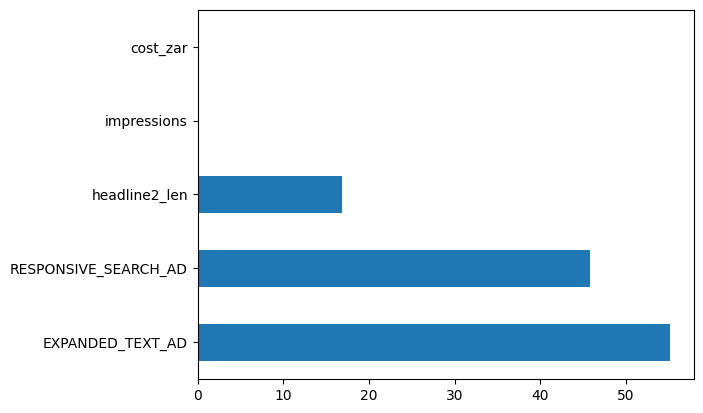

In [ ]:
good_model.params.sort_values(ascending=False)[1:6].plot(kind="barh")

In [77]:
test = pd.read_csv("Data/SampleSubmission.csv")
test["date"] = test.ID.str[-10:].str.replace("_", "-")
test["ID"] = test.ID.str[:-11]
test["date"] = pd.to_datetime(test["date"])
test.set_index("date", inplace=True)
test

,ID,clicks
date,,
2024-01-22,ID_5da86e71bf5dee4cf5047046,0
2024-01-29,ID_5da86e71bf5dee4cf5047046,0
2024-02-21,ID_5e43c29e6279884e2827d894,0
2024-02-28,ID_5e43c29e6279884e2827d894,0
2023-12-04,ID_5e4e7b480e374330ee151305,0
...,...,...
2024-02-06,ID_6568807cbb9c4d235c5dd9a8,0
2024-02-21,ID_65a7bf329fa4627faf28390c,0
2024-02-28,ID_65a7bf329fa4627faf28390c,0


In [78]:
X_tests={}
X_trains = {}
y_trains = {}

for ID in test.ID.unique():
    X_tests[ID] = test[test["ID"]==ID]

for ID, group in data.items():
    train_exog_group = group.fillna(method="ffill").astype(int).drop(target, axis = 1)
    train_endog_group = group[target]
    X_trains[ID] = train_exog_group
    y_trains[ID] = train_endog_group


display(X_trains, y_trains, X_tests)

{'ID_5da86e71bf5dee4cf5047046':             impressions  cost_zar  headline1_len  headline2_len  \
 date                                                              
 2020-01-05         2134     46715              2              4   
 2020-01-12         3463     69443              2              4   
 2020-01-19         4074     67481              2              3   
 2020-01-26         4544     67422              2              3   
 2020-02-02         4822     65477              2              3   
 ...                 ...       ...            ...            ...   
 2023-12-17         7942    192672              4              3   
 2023-12-24         4411    159590              4              3   
 2023-12-31         4777    167627              4              3   
 2024-01-07         9524    213646              4              3   
 2024-01-14         9649    220399              4              3   
 
             ad_description_len  EXPANDED_TEXT_AD  EXPANDED_DYNAMIC_SEARCH_AD  \
 d

{'ID_5da86e71bf5dee4cf5047046': date
 2020-01-05    246.0
 2020-01-12    410.0
 2020-01-19    405.0
 2020-01-26    445.0
 2020-02-02    450.0
               ...  
 2023-12-17    527.0
 2023-12-24    279.0
 2023-12-31    353.0
 2024-01-07    817.0
 2024-01-14    798.0
 Freq: W-SUN, Name: clicks, Length: 211, dtype: float64,
 'ID_5e43c29e6279884e2827d894': date
 2020-02-16     36.0
 2020-02-23    102.0
 2020-03-01     88.0
 2020-03-08     84.0
 2020-03-15     96.0
               ...  
 2024-01-21     30.0
 2024-01-28     33.0
 2024-02-04     17.0
 2024-02-11     32.0
 2024-02-18     13.0
 Freq: W-SUN, Name: clicks, Length: 210, dtype: float64,
 'ID_5e4e7b480e374330ee151305': date
 2020-03-08     0.0
 2020-03-15     0.0
 2020-03-22     1.0
 2020-03-29     2.0
 2020-04-05    45.0
               ... 
 2023-10-29    25.0
 2023-11-05    28.0
 2023-11-12    28.0
 2023-11-19    29.0
 2023-11-26    24.0
 Freq: W-SUN, Name: clicks, Length: 195, dtype: float64,
 'ID_5e8ad56cd4090270567b6c58': date

{'ID_5da86e71bf5dee4cf5047046':                                      ID  clicks
 date                                           
 2024-01-22  ID_5da86e71bf5dee4cf5047046       0
 2024-01-29  ID_5da86e71bf5dee4cf5047046       0,
 'ID_5e43c29e6279884e2827d894':                                      ID  clicks
 date                                           
 2024-02-21  ID_5e43c29e6279884e2827d894       0
 2024-02-28  ID_5e43c29e6279884e2827d894       0,
 'ID_5e4e7b480e374330ee151305':                                      ID  clicks
 date                                           
 2023-12-04  ID_5e4e7b480e374330ee151305       0
 2023-12-11  ID_5e4e7b480e374330ee151305       0,
 'ID_5e8ad56cd4090270567b6c58':                                      ID  clicks
 date                                           
 2024-02-21  ID_5e8ad56cd4090270567b6c58       0
 2024-02-28  ID_5e8ad56cd4090270567b6c58       0,
 'ID_5e8b4f12d8709943490cd775':                                      ID  clicks
 date   

In [88]:
forecasts={}

for (ID, X_train_group), X_test_group, y_train_group in zip(X_trains.items(), X_tests.values(), y_trains.values()):
    history = y_train_group.copy()
    dummy_exog = np.zeros((2, X_train_group.shape[1]))
    model = ARIMA(endog=history, exog = X_train_group, order=(1,1,1)).fit()
    forecast_results = model.forecast(steps=2, exog=dummy_exog)
    forecasts[ID] = [pd.Series(forecast_results), model.params.sort_values(ascending=False)[:5].index.to_list()]

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

In [113]:
single_predictions=forecasts["ID_5da86e71bf5dee4cf5047046"]
single_predictions

[2024-01-21    313.651949
 2024-01-28    313.040868
 Freq: W-SUN, Name: predicted_mean, dtype: float64,
 ['sigma2',
  'EXPANDED_TEXT_AD',
  'RESPONSIVE_SEARCH_AD',
  'headline2_len',
  'impressions']]

In [152]:
final_predictions = pd.DataFrame({"clicks": single_predictions[0]})
for i in range(5):
    final_predictions[i] = single_predictions[1][i]

for client, predictions in forecasts.items():
    client_predictions = pd.DataFrame({"clicks": forecasts[client][0]})
    client_predictions["IDs"] = client
    for i in range(0,5):
        client_predictions[i] = single_predictions[1][i]
    final_predictions = pd.concat([final_predictions, client_predictions], axis = 0)
final_predictions.dropna(inplace=True)
final_predictions= final_predictions.reset_index()
final_predictions["clicks"]= final_predictions["clicks"].apply(lambda row : 0 if row<0 else row).astype(int)
final_predictions["ID"] = final_predictions["IDs"] + "_" + final_predictions["index"].astype(str)
final_predictions.drop(columns = ["index", "IDs"], inplace=True)

In [153]:
display(final_predictions)

,clicks,0,1,2,3,4,ID
0,313,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_5da86e71bf5dee4cf5047046_2024-01-21
1,313,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_5da86e71bf5dee4cf5047046_2024-01-28
2,0,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_5e43c29e6279884e2827d894_2024-02-25
3,0,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_5e43c29e6279884e2827d894_2024-03-03
4,0,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_5e4e7b480e374330ee151305_2023-12-03
...,...,...,...,...,...,...,...
365,9,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_6568807cbb9c4d235c5dd9a8_2024-02-11
366,0,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_65a7bf329fa4627faf28390c_2024-02-25
367,0,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_65a7bf329fa4627faf28390c_2024-03-03
368,1686,sigma2,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,headline2_len,impressions,ID_65b0f65c7fe62e56c5593d55_2024-02-25


In [154]:
final_predictions.to_csv("Data/Submission.csv")

In [92]:
final_predictions = pd.DataFrame({
    "Clicks":[[0]],
    "Predictors":[forecasts["ID_5da86e71bf5dee4cf5047046"][1]]
})

TypeError: DataFrame.__init__() got an unexpected keyword argument 'axis'

In [90]:
final_predictions

,Clicks,Predictors
0,2024-01-21 313.651949 2024-01-28 313.040...,"[sigma2, EXPANDED_TEXT_AD, RESPONSIVE_SEARCH_A..."


In [87]:
for the, group in forecasts.items():
    print(group[0].astype(int), group[1])

2024-01-21    313
2024-01-28    313
Freq: W-SUN, Name: predicted_mean, dtype: int32 Index(['sigma2', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD', 'headline2_len',
       'impressions'],
      dtype='object')
2024-02-25   -16
2024-03-03   -15
Freq: W-SUN, Name: predicted_mean, dtype: int32 Index(['sigma2', 'EXPANDED_DYNAMIC_SEARCH_AD', 'ad_description_len',
       'EXPANDED_TEXT_AD', 'ar.L1'],
      dtype='object')
2023-12-03   -1
2023-12-10   -2
Freq: W-SUN, Name: predicted_mean, dtype: int32 Index(['sigma2', 'ar.L1', 'impressions', 'cost_zar', 'RESPONSIVE_SEARCH_AD'], dtype='object')
2024-02-25    12
2024-03-03    14
Freq: W-SUN, Name: predicted_mean, dtype: int32 Index(['sigma2', 'ad_description_len', 'headline2_len', 'RESPONSIVE_SEARCH_AD',
       'ar.L1'],
      dtype='object')
2023-09-24    6
2023-10-01    6
Freq: W-SUN, Name: predicted_mean, dtype: int32 Index(['sigma2', 'EXPANDED_TEXT_AD', 'headline2_len',
       'EXPANDED_DYNAMIC_SEARCH_AD', 'impressions'],
      dtype='object')

In [80]:
forecasts

{'ID_5da86e71bf5dee4cf5047046': [2024-01-21    313.651949
  2024-01-28    313.040868
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  Index(['sigma2', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD', 'headline2_len',
         'impressions'],
        dtype='object')],
 'ID_5e43c29e6279884e2827d894': [2024-02-25   -16.039102
  2024-03-03   -15.942485
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  Index(['sigma2', 'EXPANDED_DYNAMIC_SEARCH_AD', 'ad_description_len',
         'EXPANDED_TEXT_AD', 'ar.L1'],
        dtype='object')],
 'ID_5e4e7b480e374330ee151305': [2023-12-03   -1.745636
  2023-12-10   -2.293514
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  Index(['sigma2', 'ar.L1', 'impressions', 'cost_zar', 'RESPONSIVE_SEARCH_AD'], dtype='object')],
 'ID_5e8ad56cd4090270567b6c58': [2024-02-25    12.978693
  2024-03-03    14.253989
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  Index(['sigma2', 'ad_description_len', 'headline2_len', 'RESPONSIVE_SEARCH_AD',
         

In [ ]:
for client, forecast in forecasts.items():
    forecast = pd.DataFrame(forecast)

forecasts    


{'ID_5da86e71bf5dee4cf5047046': [2024-01-21    116.567554
  2024-01-28    116.341048
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  sigma2                  1591.942255
  EXPANDED_TEXT_AD          55.136635
  RESPONSIVE_SEARCH_AD      45.783775
  headline2_len             16.814237
  impressions                0.066607
  dtype: float64],
 'ID_5e43c29e6279884e2827d894': [2024-02-25   -6.518669
  2024-03-03   -6.489310
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  sigma2                        33.899744
  EXPANDED_DYNAMIC_SEARCH_AD     1.707375
  ad_description_len             0.825813
  EXPANDED_TEXT_AD               0.290760
  ar.L1                          0.027536
  dtype: float64],
 'ID_5e4e7b480e374330ee151305': [2023-12-03   -4.494371
  2023-12-10   -4.884608
  Freq: W-SUN, Name: predicted_mean, dtype: float64,
  sigma2         56.447674
  ar.L1           0.109883
  month           0.092912
  impressions     0.021095
  cost_zar        0.000994
  dtype: float64],
 '